# Enunciado

Intenta aplicar lo aprendido con las lecciones de ingeniería de propiedades con el conjunto de datos de Titanic disponible en Kaggle. Este dataset es accesible y contiene una mezcla de tipos de datos categóricos y numéricos, lo que lo hace perfecto para ejercitar diversas técnicas de ingeniería de propiedades. La tarea consiste en predecir la supervivencia de los pasajeros del Titanic utilizando machine learning.

Tareas Específicas:

1. Análisis Exploratorio de Datos (EDA): Buscar valores faltantes e identifica las posibles relaciones entre las características y la variable objetivo.

2. Limpieza de Datos: Basándose en el EDA debes tratar los valores faltantes y corregir posibles errores en los datos

3. Construye un modelo base para poder comparar sus resultados con otros después de aplicar ingeniería de propiedades.

4.  Elimina las características irrelevantes y prueba el modelo, si no hay mejora no las quites. 

5. Aplicar técnicas de ingeniería de propiedades para transformar y crear nuevas características. Algunas sugerencias:

Crea una característica de "Tamaño de la familia" sumando las características SibSp (número de hermanos/cónyuges a bordo) y Parch (número de padres/hijos a bordo).
Extrae el título de la característica Name y usarlo para crear una nueva característica que pueda indicar el estatus social o el género, lo que podría influir en la supervivencia.
Crea bandas de edad para transformar la edad en una característica categórica, facilitando la captura de relaciones no lineales con la supervivencia.
Aplica target encoding a la característica Cabin considerando la letra de la cabina como una indicación de la cubierta, lo que podría afectar las posibilidades de supervivencia.
Prueba con random forest.

## Cargamos los datos

In [478]:
# Cargar datos del Titanic
import pandas as pd

train, test = pd.read_csv('csv/train.csv'), pd.read_csv('csv/test.csv')
original_train = train.copy() # Copia de los datos originales para trabajar con ellos sin modificar los originales

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Análisis Exploratorio de Datos (EDA)

In [479]:
# Información de los datos
print(f"Cantidad de filas y columnas: {train.shape}\n=======================================") # Muestra la cantidad de filas y columnas
train.info() # Muestra información de las columnas y los tipos de datos

Cantidad de filas y columnas: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Valores únicos

In [480]:
# Valores únicos de las columnas
unique_values = train.nunique()
unique_values = pd.DataFrame({'Columna': unique_values.index, 'Valores únicos': unique_values.values})
print(unique_values)

        Columna  Valores únicos
0   PassengerId             891
1      Survived               2
2        Pclass               3
3          Name             891
4           Sex               2
5           Age              88
6         SibSp               7
7         Parch               7
8        Ticket             681
9          Fare             248
10        Cabin             147
11     Embarked               3


Eliminamos las columnas `PassengerId`, `Name` y `Ticket` ya que son valores únicos y no aportan información relevante.

In [481]:
train.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

### Valores faltantes

In [482]:
# Tabla de valores faltantes (Columnas, Cantidad de valores totales, Cantidad de valores faltantes)
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = pd.DataFrame({'Columna': missing_values.index, 'Cantidad de valores totales': train.shape[0], 'Cantidad de valores faltantes': missing_values.values})
print(missing_values)

    Columna  Cantidad de valores totales  Cantidad de valores faltantes
0       Age                          891                            177
1     Cabin                          891                            687
2  Embarked                          891                              2


Como podemos observar, las columnas `Age`, `Cabin` y `Embarked` tienen valores faltantes. Vamos a tratar estos valores faltantes. Para la columna `Age` vamos a realizar un estudio para saber si es mejor usar la mediana o la media. Para la columna `Embarked` vamos a reemplazar los valores faltantes por la moda de la columna. La columna `Cabin` vamos a eliminarla, ya que tiene muchos valores faltantes.

Media de la edad: 29.69911764705882
Mediana de la edad: 28.0


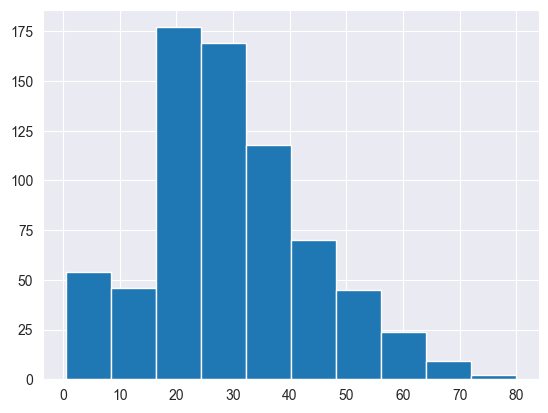

In [483]:
# Mostrar edades
train['Age'].hist()

# Media de la edad y mediana
print(f"Media de la edad: {train['Age'].mean()}")
print(f"Mediana de la edad: {train['Age'].median()}")

Como podemos observar, la media y la mediana de la columna `Age` son muy similares. En nuestro caso nos quedaremos con la mediana ya que es menos sensible a los valores influyentes.

In [484]:
# Edad mediana
train['Age'] = train['Age'].fillna(train['Age'].median())

In [485]:
# Reemplazar valores faltantes
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [486]:
# Eliminar la columna 'Cabin'
train.drop('Cabin', axis=1, inplace=True)

### Modelo base

Ahora realizaremos la codificación one-hot de las columnas categóricas.

In [487]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns_train = train.select_dtypes(include=['object'])
encoder = OneHotEncoder()
encoded_columns_train = encoder.fit_transform(categorical_columns_train)
feature_names_train = encoder.get_feature_names_out(categorical_columns_train.columns)
encoded_columns_df_train = pd.DataFrame(encoded_columns_train.toarray(), columns=feature_names_train)

train = pd.concat(
    [train.drop(categorical_columns_train.columns, axis=1), encoded_columns_df_train], axis=1)

train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [488]:
# Modelo base
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train.drop('Survived', axis=1)
y = train['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8103571652752495


Voy a crear una variable para ir almacenando los modelos y compararlos al final.

In [489]:
models_scores = {}

In [490]:
models_scores['Modelo Base'] = model_score.mean()

### Mutual Information

In [491]:
# Mutual Information con la variable objetivo 'Survived' para las columnas numéricas
from sklearn.feature_selection import mutual_info_regression

train = original_train.copy()
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

X = train.select_dtypes(include=['int64', 'float64']).drop('Survived', axis=1, inplace=False)
y = train['Survived']

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Fare      0.144758
Pclass    0.037004
Age       0.000000
SibSp     0.000000
Parch     0.000000
Name: MI Scores, dtype: float64

In [492]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores (Numerical Features)")

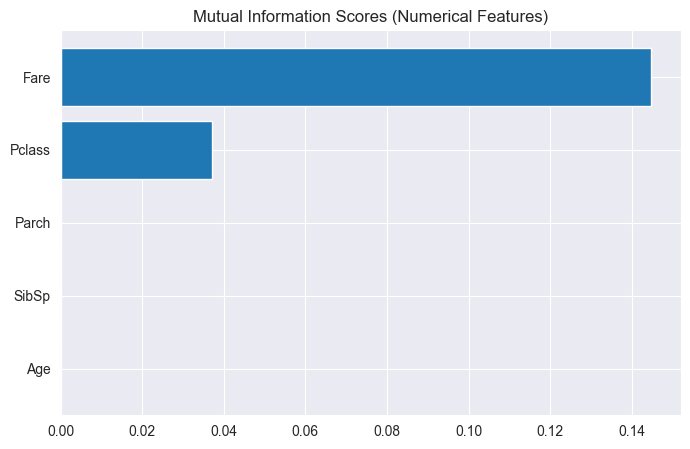

In [493]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [494]:
# Mutual Information con la variable objetivo 'Survived' para las columnas categóricas
from sklearn.feature_selection import mutual_info_classif

X = train.select_dtypes(include=['object'])
y = train['Survived']

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Sex         0.153975
Embarked    0.009310
Name: MI Scores, dtype: float64

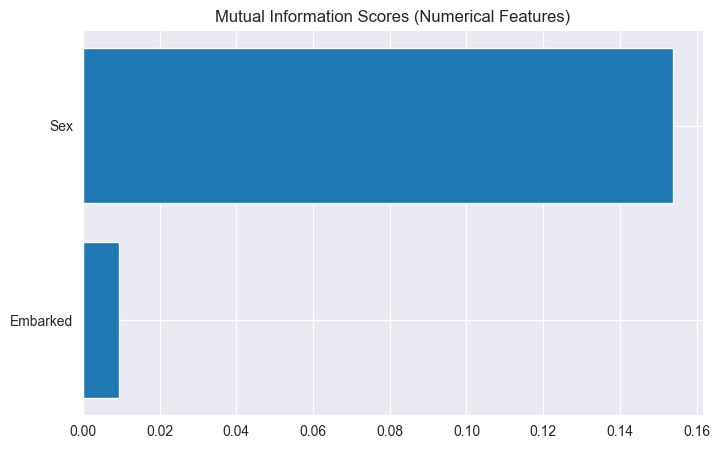

In [495]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Como podemos observar, las columnas `Parch` y `Embarked` son las que no aportan información de la variable objetivo `Survived`. Por lo tanto, vamos a eliminarlas para realizar el modelo base.
En nuestro caso la columna `Embarked` no le vamos a realizar una ingeniería de propiedades, ya que no aporta información relevante. Mientras que la columna `Parch` le vamos a realizar una ingeniería de propiedades para ver si mejora el modelo, la agregaremos en su apartado correspondiente.

In [496]:
train.drop(['Parch', 'Embarked'], axis=1, inplace=True)

Realizaremos el one-hot encoding de las columnas categóricas.

In [497]:
categorical_columns_train = train.select_dtypes(include=['object'])
encoder = OneHotEncoder()
encoded_columns_train = encoder.fit_transform(categorical_columns_train)
feature_names_train = encoder.get_feature_names_out(categorical_columns_train.columns)
encoded_columns_df_train = pd.DataFrame(encoded_columns_train.toarray(), columns=feature_names_train)

train = pd.concat(
    [train.drop(categorical_columns_train.columns, axis=1), encoded_columns_df_train], axis=1)

train.head()

,Survived,Pclass,Age,SibSp,Fare,Sex_female,Sex_male
0,0,3,22.0,1,7.2500,0.0,1.0
1,1,1,38.0,1,71.2833,1.0,0.0
2,1,3,26.0,0,7.9250,1.0,0.0
3,1,1,35.0,1,53.1000,1.0,0.0
4,0,3,35.0,0,8.0500,0.0,1.0


### ¿Mejora el modelo con la media en la edad en vez de la mediana?

In [498]:
train_age_mean = train.copy()
train_age_mean.drop('Age', axis=1, inplace=True)
# Añadir columna 'Age' con la mediana de la edad del conjunto de datos original
train_age_mean['Age'] = original_train['Age']
train_age_mean['Age'] = train_age_mean['Age'].fillna(train_age_mean['Age'].mean())
train_age_mean.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age
0,0,3,1,7.2500,0.0,1.0,22.0
1,1,1,1,71.2833,1.0,0.0,38.0
2,1,3,0,7.9250,1.0,0.0,26.0
3,1,1,1,53.1000,1.0,0.0,35.0
4,0,3,0,8.0500,0.0,1.0,35.0


In [499]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_age_mean.drop('Survived', axis=1)
y = train_age_mean['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo Con La Media'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8092586780490867


In [500]:
train.drop('Age', axis=1, inplace=True)
train['Age'] = train_age_mean['Age']

Ahora vemos a ver si con la mediana mejora el modelo.

### ¿Mejora el modelo con la mediana en la edad en vez de la media?

In [501]:
train_age_median = train.copy()
train_age_median.drop('Age', axis=1, inplace=True)
# Añadir columna 'Age'
train_age_median['Age'] = original_train['Age']
train_age_median['Age'] = train_age_median['Age'].fillna(train_age_median['Age'].median())
train_age_median.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age
0,0,3,1,7.2500,0.0,1.0,22.0
1,1,1,1,71.2833,1.0,0.0,38.0
2,1,3,0,7.9250,1.0,0.0,26.0
3,1,1,1,53.1000,1.0,0.0,35.0
4,0,3,0,8.0500,0.0,1.0,35.0


In [502]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_age_median.drop('Survived', axis=1)
y = train_age_median['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo Con La Mediana'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8114995919904588


Como podemos observar el rendimiento del modelo ha aumentado, por lo que vamos a utilizar la mediana.

In [503]:
train.drop('Age', axis=1, inplace=True)
train['Age'] = train_age_median['Age']

### ¿Mejora el modelo con la extracción del título de la columna Name?

In [504]:
# Extraer el título de la columna 'Name' y crear la columna 'Title'
train['Title'] = original_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Reemplazar títulos raros por 'Rare'
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

# Reemplazar títulos en otros idiomas por su traducción en inglés
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

In [505]:
# Unicos
print(train['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


Al haber poca cardinalidad en la columna `Title`, vamos a realizar la codificación one-hot.

In [506]:
from sklearn.preprocessing import OneHotEncoder

train_name = train.copy()

categorical_columns_base_model = train_name.select_dtypes(include=['object'])
encoder = OneHotEncoder()
encoded_columns_base_model = encoder.fit_transform(categorical_columns_base_model)
feature_names_base_model = encoder.get_feature_names_out(categorical_columns_base_model.columns)
encoded_columns_df_base_model = pd.DataFrame(encoded_columns_base_model.toarray(), columns=feature_names_base_model)

train_name = pd.concat(
    [train_name.drop(categorical_columns_base_model.columns, axis=1), encoded_columns_df_base_model], axis=1)

train_name.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0


In [507]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_name.drop('Survived', axis=1)
y = train_name['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo Extracción Name'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8182160567447117


Como podemos observar el rendimiento del modelo ha aumentado.

In [508]:
train = train_name.copy()

### ¿Mejora el modelo con la creación de la característica FamilySize?

Ahora es cuando volvemos a añadir las columnas `SibSp` y `Parch` para realizar la ingeniería de propiedades.

In [509]:
train_family_size = train.copy().drop('SibSp', axis=1)

# Tamaño de la familia
train_family_size['FamilySize'] = train['SibSp'] + original_train['Parch'] + 1 # +1 para incluir al pasajero

# Eliminar las columnas 'SibSp' y 'Parch'
# train_family_size.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [510]:
train_family_size.head()

,Survived,Pclass,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize
0,0,3,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,2
1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0,2
2,1,3,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0,1
3,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0,2
4,0,3,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0,1


In [511]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_family_size.drop('Survived', axis=1)
y = train_family_size['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo FamilySize'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8182035026049841


Como podemos observar, el rendimiento del modelo ha disminuido, por lo que no vamos a utilizar la característica `FamilySize`.

### ¿Mejora el modelo con la creación de bandas de edad?

In [512]:
train.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0


In [513]:
train_age_band = train.copy()

In [514]:
# Edad en bandas
train_age_band['AgeBand'] = pd.cut(train['Age'], 5)
# Eliminar la columna 'Age'
train_age_band.drop('Age', axis=1, inplace=True)

In [515]:
# Cambiar el tipo de dato de la columna 'AgeBand' a string
train_age_band['AgeBand'] = train_age_band['AgeBand'].astype(str)
train_age_band['AgeBand'].head()

0    (16.336, 32.252]
1    (32.252, 48.168]
2    (16.336, 32.252]
3    (32.252, 48.168]
4    (32.252, 48.168]
Name: AgeBand, dtype: object

In [516]:
categorical_columns_base_model = train_age_band.select_dtypes(include=['object'])
encoder = OneHotEncoder()
encoded_columns_base_model = encoder.fit_transform(categorical_columns_base_model)
feature_names_base_model = encoder.get_feature_names_out(categorical_columns_base_model.columns)
encoded_columns_df_base_model = pd.DataFrame(encoded_columns_base_model.toarray(), columns=feature_names_base_model)

train_age_band = pd.concat(
    [train_age_band.drop(categorical_columns_base_model.columns, axis=1), encoded_columns_df_base_model], axis=1)

train_age_band.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,"AgeBand_(0.34, 16.336]","AgeBand_(16.336, 32.252]","AgeBand_(32.252, 48.168]","AgeBand_(48.168, 64.084]","AgeBand_(64.084, 80.0]"
0,0,3,1,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,1,71.2833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,3,0,7.9250,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,53.1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,3,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [517]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_age_band.drop('Survived', axis=1)
y = train_age_band['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo Bandas Edad One Hot Encoding'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8002699140041429


Ahora lo haré con Target Encoding, para ver si mejora el modelo.

In [518]:
train_age_band = train.copy()

In [519]:
# Edad en bandas
train_age_band['AgeBand'] = pd.cut(train['Age'], 5)
# Eliminar la columna 'Age'
train_age_band.drop('Age', axis=1, inplace=True)

In [520]:
# Cambiar el tipo de dato de la columna 'AgeBand' a string
train_age_band['AgeBand'] = train_age_band['AgeBand'].astype(str)
train_age_band['AgeBand'].head()

0    (16.336, 32.252]
1    (32.252, 48.168]
2    (16.336, 32.252]
3    (32.252, 48.168]
4    (32.252, 48.168]
Name: AgeBand, dtype: object

In [521]:
# Target encoding a la columna 'AgeBand'
train_age_band['AgeBand'] = train_age_band['AgeBand'].map(train_age_band.groupby('AgeBand')['Survived'].mean())

train_age_band.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeBand
0,0,3,1,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.344168
1,1,1,1,71.2833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.404255
2,1,3,0,7.9250,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.344168
3,1,1,1,53.1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.404255
4,0,3,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.404255


In [522]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_age_band.drop('Survived', axis=1)
y = train_age_band['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo Bandas Edad Target Encondig'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.8092335697696313


Como podemos observar, el rendimiento del modelo ha disminuido en ambos casos, por lo que no vamos a utilizar la característica `AgeBand`.

In [523]:
train.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0


### ¿Mejora el modelo con el target encoding de la columna Cabin?

In [524]:
train_cabin = train.copy()
train_cabin['Cabin'] = original_train['Cabin']
train_cabin.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Cabin
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,NaN
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0,C85
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0,NaN
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0,C123
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0,NaN


In [525]:
train_cabin['Cabin'] = train_cabin['Cabin'].str[0]
train_cabin.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Cabin
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,NaN
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0,C
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0,NaN
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0,C
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0,NaN


In [526]:
print(train_cabin['Cabin'].value_counts())
print(train_cabin['Cabin'].unique())

Cabin
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64
[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


In [527]:
train_cabin['Cabin'] = train_cabin['Cabin'].fillna('Unknown')

In [528]:
# Target encoding a la columna 'Cabin'
train_cabin['Cabin'] = train_cabin['Cabin'].map(train_cabin.groupby('Cabin')['Survived'].mean())

train_cabin.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Cabin
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,0.299854
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0,0.593220
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0,0.299854
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0,0.593220
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0,0.299854


In [529]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train_cabin.drop('Survived', axis=1)
y = train_cabin['Survived']

model = RandomForestClassifier(criterion="gini", random_state=42)
model_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')

models_scores['Modelo Cabin Target Encoding'] = model_score.mean()

print(f"Modelo base: {model_score.mean()}")

Modelo base: 0.824938798568828


Como podemos observar, el rendimiento del modelo ha aumentado, por lo que vamos a utilizar la característica `Cabin`.

In [530]:
train = train_cabin.copy()

## Construcción del modelo final

In [531]:
train.head()

,Survived,Pclass,SibSp,Fare,Sex_female,Sex_male,Age,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Cabin
0,0,3,1,7.2500,0.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,0.299854
1,1,1,1,71.2833,1.0,0.0,38.0,0.0,0.0,0.0,1.0,0.0,0.593220
2,1,3,0,7.9250,1.0,0.0,26.0,0.0,1.0,0.0,0.0,0.0,0.299854
3,1,1,1,53.1000,1.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0,0.593220
4,0,3,0,8.0500,0.0,1.0,35.0,0.0,0.0,1.0,0.0,0.0,0.299854


### Preparación del conjunto de datos

In [532]:
from sklearn.model_selection import train_test_split

p_train = 0.7

train, test = train_test_split(train, train_size=p_train, random_state=42)

# inplace=True: Modifica el dataframe original en lugar de devolver uno nuevo
train.reset_index(inplace=True)
test.reset_index(inplace=True)

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

print("Conjunto de entrenamiento:")
print(train.head())

print("Conjunto de prueba:")
print(test.head())

Train: (623, 14)
Test: (268, 14)
Conjunto de entrenamiento:
   index  Survived  Pclass  SibSp     Fare  Sex_female  Sex_male   Age  \
0    445         1       1      0  81.8583         0.0       1.0   4.0   
1    650         0       3      0   7.8958         0.0       1.0  28.0   
2    172         1       3      1  11.1333         1.0       0.0   1.0   
3    450         0       2      1  27.7500         0.0       1.0  36.0   
4    314         0       2      1  26.2500         0.0       1.0  43.0   

   Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare     Cabin  
0           1.0         0.0       0.0        0.0         0.0  0.466667  
1           0.0         0.0       1.0        0.0         0.0  0.299854  
2           0.0         1.0       0.0        0.0         0.0  0.299854  
3           0.0         0.0       1.0        0.0         0.0  0.299854  
4           0.0         0.0       1.0        0.0         0.0  0.299854  
Conjunto de prueba:
   index  Survived  Pclass  SibSp    

In [533]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

parametros = {
    "criterion": ["gini","entropy"],
    "max_depth":range(1, 20),
    "n_estimators" : [2, 4, 8, 16, 32, 64, 128, 256]
}

modelo = RandomForestClassifier()

rf = RandomizedSearchCV(estimator = modelo, param_distributions=parametros, n_iter=100, cv = 5)

X_train = train.drop("Survived", axis = 1)
y_train = train["Survived"]
print(type(X_train))
rf.fit(X_train, y_train)

rf.best_params_

<class 'pandas.core.frame.DataFrame'>


{'n_estimators': 8, 'max_depth': 6, 'criterion': 'entropy'}

In [534]:
tree_model = rf.best_estimator_

model = tree_model.fit(X_train, y_train)

X_test = test.drop("Survived", axis=1)

preds = model.predict(X_test)

Metrics 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       157
           1       0.84      0.72      0.78       111

    accuracy                           0.83       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



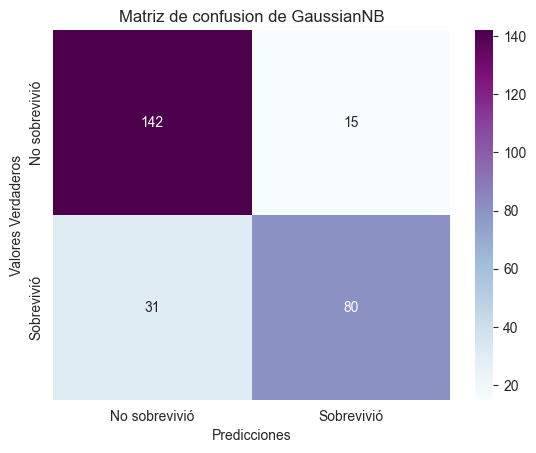

In [535]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Metrics \n" + classification_report(y_true=test['Survived'], y_pred=preds))

classes = ['No sobrevivió', 'Sobrevivió']

cm = confusion_matrix(test['Survived'], preds)
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d', xticklabels=classes, yticklabels=classes)

models_scores['Modelo Final'] = model.score(X_test, test['Survived'])

plt.title('Matriz de confusion de GaussianNB')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

## Conclusiones

In [536]:
models_scores_copy = models_scores.copy()
models_scores_draw = {k: v * 100 for k, v in models_scores_copy.items()}

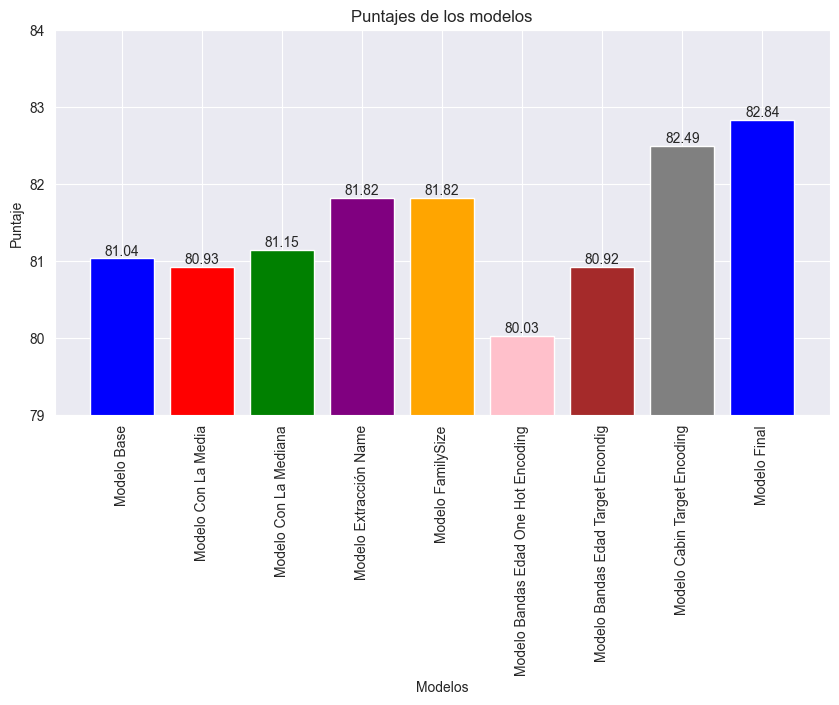

In [537]:
plt.figure(figsize=(10, 5))
plt.bar(models_scores_draw.keys(), models_scores_draw.values(), color=['blue', 'red', 'green', 'purple', 'orange', 'pink', 'brown', 'gray'])
plt.ylim(79, 84)
# Mostrar el valor en cada barra
for i, v in enumerate(models_scores_draw.values()):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.xticks(rotation=90)
plt.title('Puntajes de los modelos')
plt.ylabel('Puntaje')
plt.xlabel('Modelos')
plt.show()

Aquí podemos observar un gráfico con los puntajes de los modelos. Como podemos observar, el modelo final tiene el mejor rendimiento, ya que es el que tiene todos los cambios realizados para optimizarlo.